# Web-scraping of Bol.com

This notebooks contains a scapring tool of Bol.com using Python's beautiful soup. The goal of this program is to export a dataframe which can be used to compare Bol.com with CoolBlue in my other program. 

Let's what the website looks like.

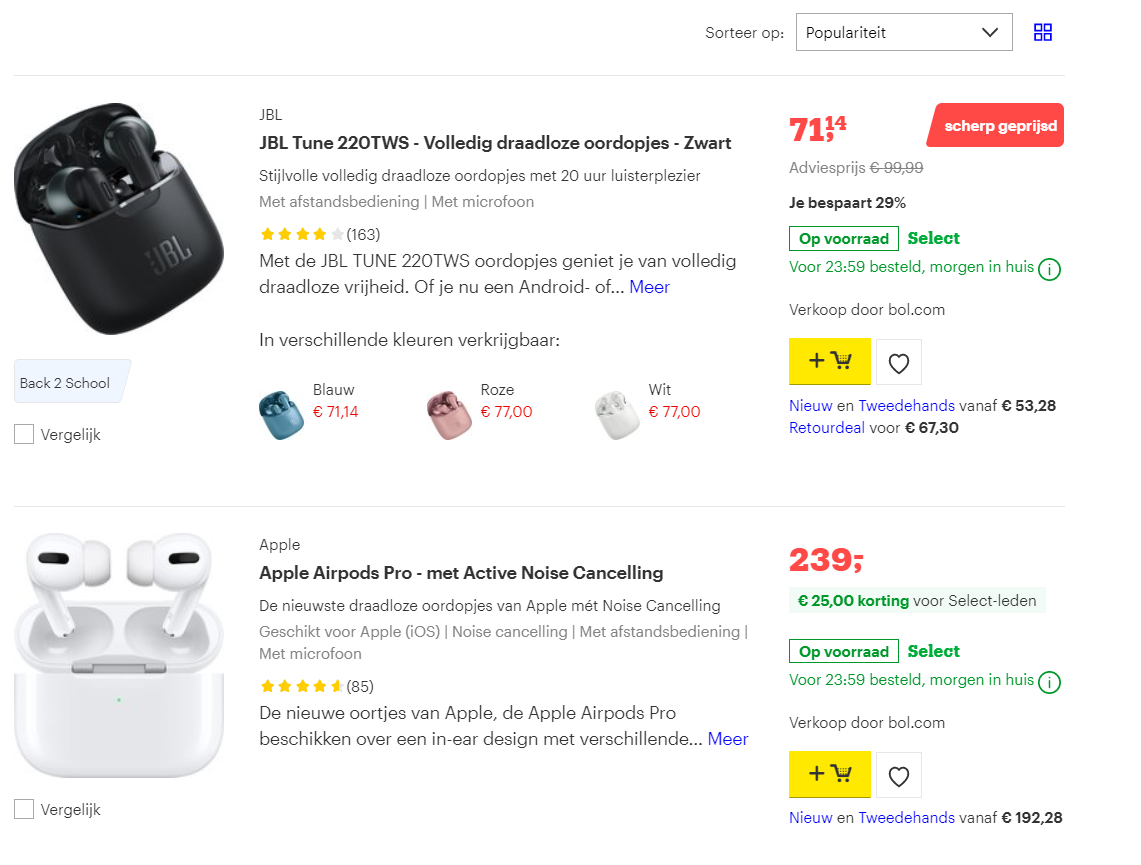

In [1]:
from IPython.display import Image
Image(filename='Bol.png') 

In [13]:
import os
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
from math import nan

## REQUIRED FUNCTIONS
def join_string(word_list):
    string=''
    for word in word_list:
        string=string+' '+word
    return string[1:]

def price_list_to_price(price_list):
    if len(price_list)==1:
        return price_list[0]
    else:
        return price_list[0]+price_list[1]/100
    
def discount_list_to_discount(price_list):
    if len(price_list)==1:
        return price_list[0]
    else:
        return price_list[0]*10+price_list[1]
    
def get_digits(str1):
    c = ""
    for i in str1:
        if i.isdigit():
            c += i
    return c

Let's start by reading the first product page:

In [4]:
url = "https://www.bol.com/nl/l/volledig-draadloze-oordopjes/N/8440+44349/?page=1"

page_read = BeautifulSoup(requests.get(url).text, 'html5lib')
products = page_read.find_all("li",{"class":'product-item--row'})
product=products[0]
len(products)

22

We have 22 products per page so that's correct. The soup is split in 22 products.

In [5]:
Man_name=product.find('ul','product-creator').a.text
Prod_name=product.find('div','product-title--inline').a.text

print(Man_name)
print(Prod_name)

JBL
JBL Tune 220TWS - Volledig draadloze oordopjes - Zwart


This is not the same as on the picture since the website changes. 

In [6]:
try:
    Price_string=product.find('span','promo-price').text
    Price_list=[int(s) for s in Price_string.split() if s.isdigit()] #Convert to ints
    Price=price_list_to_price(Price_list) #Concat int list to a price
except:
    Price=nan
## Let's identify the discount items and calculate the normal retail price
try:
    Discount_string=product.select('p[class*="product-prices"]')[0].strong.text
    Discount=Discount_string.split()[-1]

    Discount_list=[int(i) for i in list(Discount)[:-1]] 
    Retail_price=100*Price/(100-discount_list_to_discount(Discount_list))
except IndexError:
    Discount = '0%'
    Retail_price=Price
    
print('Current price, ',Price,' EUR')
print('Retail price,  ',Retail_price,' EUR')
print('Discount rate, ',Discount)

Current price,  71.14  EUR
Retail price,   100.19718309859155  EUR
Discount rate,  29%


Now, let's see what the general review for each product is:

In [7]:
Stars=product.find('div',{'class':'star-rating'}).get('title').split()[1]
Star_count=product.find('div',{'class':'star-rating'}).get('data-count')
print('Stars, ', Stars)
print('# Reviewers, ', Star_count)

Stars,  4.0
# Reviewers,  165


Allright, now let's zoom in on each product by itself.

In [8]:
product_url=product.find('p',{'class':'medium--is-visible'}).a.get('href')
product_page_read = BeautifulSoup(requests.get('https://www.bol.com/' +product_url).text, 'html5lib')        

In [9]:
descr=product_page_read.find('div',{'data-test':'description'}).text.split()
descr=' '.join(descr)
descr

'Met de JBL TUNE 220TWS oordopjes geniet je van volledig draadloze vrijheid. Of je nu een Android- of een iPhone-apparaat gebruikt, je blijft de hele dag verbonden zonder dat kabels je in de weg zitten. Deze ergonomische draadloze oordopjes zijn ontworpen om je 20 uur lang te voorzien van hoge kwaliteit JBL Pure Bass-geluid. Schakel moeiteloos tussen oproepen, muziek en je stemassistent. De oordopjes zijn metallic afgewerkt met soft-touch verf en verkrijgbaar in klassiek wit of trendy kleuren. Kies een set die net zo uniek en stylish is als jij. Kenmerken van de JBL TUNE 220TWS: JBL Pure Bass JBL TUNE 220TWS oordopjes nemen geen genoegen met gemiddeld geluid. Ze gaan voor ongeevenaarde audio. Met de 12,5 mm driver voor JBL Pure Bass Sound bieden ze je weergaloos geluid. 20 uur gecombineerde speeltijd Je zit nooit zonder muziek; Groots geluid in een kleine verpakking. Deze oordopjes geven je 3 uur non-stop geluid plus 17 uur vanuit de oplaadhouder, en dat alles in zakformaat. Blijf verb

In the comparison project I would like to use NLP to compare review and ratings. So for each product we need some reviews. I also added the reviewer's grade for per review for each earbud. Let's get them scrapped:

In [15]:
## REVIEWS         
reviews=product_page_read.find_all('div',{'class':'review__body'})
review_list=[]

review_stars=product_page_read.find_all('div',{'class':'star-rating'})

for i in range(0,len(reviews)):
    review=reviews[i].p.text.split()
    review_star=float(get_digits(review_stars[i+12].span.get('style')))/20
    review_list.append(' '.join(review)+', '+ str(review_star))

print('# Reviews', len(review_list))
print(' ')
print(review_list[0])

# Reviews 10
 
Volgende dag in huis door bol.com! Makkelijk te installeren en zeer fijn geluid, vooral de bass. Zelfs op de laagste stand van het volume nog alles makkelijk te verstaan. Het geluid wordt niet helemaal afgesloten, maar dat is voor mij geen probleem.Goede verbinding, rijkt ver, en de houder is ook van goede kwaliteit. Bij eerdere oortjes vaak vertraging bij het kijken van video's, maar bij deze niet.Wat ik niet wist is dat de oortjes maar met 1 apparaat tegelijk verbonden kunnen zijn, logisch ook eigenlijk. Dus wanneer je wilt switchen van telefoon naar laptop moet je de bluetooth uitzetten, en op het andere apparaat aan.Heb kleine oren maar deze zitten fijn, draag ze wel iets meer naar beneden anders kreeg ik na een lange tijd wel last. Ze hadden voor mij persoonlijk ietsjes kleiner gemogen., 5.0


In [16]:
plusses=product_page_read.find_all('li',{'class':'pros-cons-list__item pros-cons-list__item--pro'})
plus_list=[]
for plus in plusses:
    plus=plus.text.split()
    plus_list.append(' '.join(plus))
print('Pros: ',plus_list)

Pros:  ['Batterij tot 20 uur', 'Hands-free bellen', 'Volledig draadloos']


In [17]:
minusses=product_page_read.find_all('li',{'class':'pros-cons-list__item pros-cons-list__item--con'})
minus_list=[]
for minus in minusses:
    minus=minus.text.split()
    minus_list.append(' '.join(minus))
print('Cons: ',minus_list)

Cons:  ['Niet waterdicht']


All the above should be looped over all products and all pages. This will be done below.

This program was unit tested while building in Spyder. For visualisation purposes it was transferred to Jupyter Notebook afterwards. Please refer to WEB_SCAPE_BOL.py for the original script. 

In [21]:
import os
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
from math import nan

## REQUIRED FUNCTIONS
def join_string(word_list):
    string=''
    for word in word_list:
        string=string+' '+word
    return string[1:]

def price_list_to_price(price_list):
    if len(price_list)==1:
        return price_list[0]
    else:
        return price_list[0]+price_list[1]/100

def discount_list_to_discount(price_list):
    if len(price_list)==1:
        return price_list[0]
    else:
        return price_list[0]*10+price_list[1]

def get_digits(str1):
    c = ""
    for i in str1:
        if i.isdigit():
            c += i
    return c
    
    
## INITIALISE VARIABLES
Bol_data=[]
url = "https://www.bol.com/nl/l/volledig-draadloze-oordopjes/N/8440+44349/?page="
endpage=13
pages=np.arange(1,endpage+1)
pages=[1]   # For debugging
for Npage in pages:   # Loop over pages
    print('Page=',Npage)
    ## READ PAGES
    page_read = BeautifulSoup(requests.get(url+str(Npage)).text, 'html5lib')
    products = page_read.findAll("li",{"class":'product-item--row'})
    
    products=products[0:3]  # For debugging
    for product in products:   # Loop over products per page
        ## MANUFACTURER AND PRODUCT NAME
        # Sometimes manufacurer is given separately, sometimes in title. Let's check this:
        Man_name=product.find('ul','product-creator').a.text
        Prod_name=product.find('div','product-title--inline').a.text
        print(Prod_name)
        if Man_name == 'Merkloos':
            Man_name=Prod_name.split()[0]
        
        if Prod_name.split()[0]==Man_name:
            Prod_name=join_string(Prod_name.split()[1:-1])
        
        ## PRICING
        try:
            Price_string=product.find('span','promo-price').text
            Price_list=[int(s) for s in Price_string.split() if s.isdigit()] #Convert to ints
            Price=price_list_to_price(Price_list) #Concat int list to a price
        except:
            Price=nan
        ## Let's identify the discount items and calculate the normal retail price
        try:
            Discount_string=product.select('p[class*="product-prices"]')[0].strong.text
            Discount=Discount_string.split()[-1]
            
            Discount_list=[int(i) for i in list(Discount)[:-1]] 
            Retail_price=100*Price/(100-discount_list_to_discount(Discount_list))
        except IndexError:
            Discount = '0%'
            Retail_price=Price
        
        ## STAR RATING
        Stars=product.find('div',{'class':'star-rating'}).get('title').split()[1]
        Star_count=product.find('div',{'class':'star-rating'}).get('data-count')
        
         # Sometimes no reviews are given yet
        if Stars == 'zijn':
            Stars = 'No stars'
            Star_count=0
        
        ## DESCRIPTION
        product_url=product.find('p',{'class':'medium--is-visible'}).a.get('href')
        product_page_read = BeautifulSoup(requests.get('https://www.bol.com/' +product_url).text, 'html5lib')
        
        try:
            descr=product_page_read.find('div',{'data-test':'description'}).text.split()
            descr=' '.join(descr)
        except:
            descr='No description'
            
        ## PROS
        plusses=product_page_read.find_all('li',{'class':'pros-cons-list__item pros-cons-list__item--pro'})
        plus_list=[]
        for plus in plusses:
            plus=plus.text.split()
            plus_list.append(' '.join(plus))

        ## CONS
        minusses=product_page_read.find_all('li',{'class':'pros-cons-list__item pros-cons-list__item--con'})
        minus_list=[]
        for minus in minusses:
            minus=minus.text.split()
            minus_list.append(' '.join(minus))
        
        ## REVIEWS         
        reviews=product_page_read.find_all('div',{'class':'review__body'})
        review_list=[]
        
        review_stars=product_page_read.find_all('div',{'class':'star-rating'})

        for i in range(0,len(reviews)):
            review=reviews[i].p.text.split()
            review_star=float(get_digits(review_stars[i+12].span.get('style')))/20
            review_list.append(' '.join(review)+', '+ str(review_star))


        Bol_data.append([Man_name,Prod_name,Price,Discount,round(Retail_price,2),Stars,Star_count,descr,plus_list,minus_list,review_list])


# Create DF
col_names=['Manufacturer','Name','Price [EUR]','Discount','Ret P [EUR]','Stars [x/5.0]', 'S_count','Description','Pros','Cons','Reviews']
EarBuds_Bol = pd.DataFrame(np.array(Bol_data),columns=col_names)
EarBuds_Bol['Price [EUR]']=EarBuds_Bol['Price [EUR]'].apply(lambda x: float(x))
EarBuds_Bol['Ret P [EUR]']=EarBuds_Bol['Ret P [EUR]'].apply(lambda x: float(x))
EarBuds_Bol['S_count']=EarBuds_Bol['S_count'].apply(lambda x: int(x))

#EarBuds_Bol.to_pickle('EarBuds_Bol')


Page= 1
JBL Tune 220TWS - Volledig draadloze oordopjes - Zwart
JBL Tune 120TWS - Zwart - Volledige draadloze oordopjes
Apple Airpods Pro - met Active Noise Cancelling


In [22]:
EarBuds_Bol.head()

,Manufacturer,Name,Price [EUR],Discount,Ret P [EUR],Stars [x/5.0],S_count,Description,Pros,Cons,Reviews
0,JBL,Tune 220TWS - Volledig draadloze oordopjes -,71.14,29%,100.20,4.0,165,Met de JBL TUNE 220TWS oordopjes geniet je van...,"[Batterij tot 20 uur, Hands-free bellen, Volle...",[Niet waterdicht],[Volgende dag in huis door bol.com! Makkelijk ...
1,JBL,Tune 120TWS - Zwart - Volledige draadloze,65.00,19%,80.25,4.1,184,Maak kennis met de nieuwste (2019) volledig dr...,"[Volledig draadloos, 16 uur batterij, Bedienin...","[In-ear pasvorm is niet voor iedereen, Niet vo...",[Ik kon al haast niet wachten tot de JBL oortj...
2,Apple,Airpods Pro - met Active Noise,239.00,0%,239.00,4.5,87,"De nieuwe oortjes van Apple, de Apple Airpods ...","[Noise cancelling en transparantie modus, Tota...",[Geen volumesensor op het oortje - wel via iPh...,[Ik had geen hoge verwachtingen van het noice ...


In [23]:
EarBuds_Bol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Manufacturer   3 non-null      object 
 1   Name           3 non-null      object 
 2   Price [EUR]    3 non-null      float64
 3   Discount       3 non-null      object 
 4   Ret P [EUR]    3 non-null      float64
 5   Stars [x/5.0]  3 non-null      object 
 6   S_count        3 non-null      int64  
 7   Description    3 non-null      object 
 8   Pros           3 non-null      object 
 9   Cons           3 non-null      object 
 10  Reviews        3 non-null      object 
dtypes: float64(2), int64(1), object(8)
memory usage: 392.0+ bytes


In [24]:
EarBuds_Bol.describe()

,Price [EUR],Ret P [EUR],S_count
count,3.000000,3.000000,3.000000
mean,125.046667,139.816667,145.333333
std,98.734222,86.472544,51.403632
min,65.000000,80.250000,87.000000
25%,68.070000,90.225000,126.000000
50%,71.140000,100.200000,165.000000
75%,155.070000,169.600000,174.500000
max,239.000000,239.000000,184.000000


All looks very good. Note that this will change when ran at different times as Bol.com is a fast changing E-comm.